# Scattering Matrix

First, test if the scattering matrix calculation works without calculatng the viewing matrix. In order to do this, we need to load up some cross section data to initialize `Gas`. Then, we need to load some neutral densities, temperature and an ionosphere to create an `Atmosphere`.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np
import scipy.integrate, scipy.interpolate
import pyauric, mcrt

In [3]:
from mcrt.test import TestAtmosphere
atmosphere = TestAtmosphere()

In [4]:
Mm = atmosphere.multiple_scatter_matrix( 2, view_height=False )

In [5]:
thin_lines = ! grep "O.*83[234] A.*initial.*" inputs/dayglo.ver 
thick_lines = ! grep "83[234].*final" inputs/dayglo.ver

(0.0001, 100)

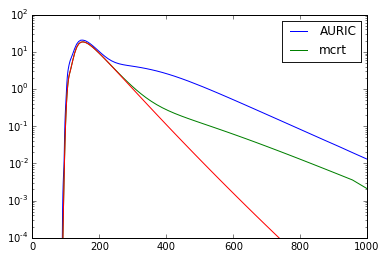

In [6]:
auric = pyauric.AURICManager('./inputs')
feautrier = auric.retrieve( "dayglo.ver", features=thick_lines )
sourcef = auric.retrieve( "dayglo.ver", features=thin_lines )
S = scipy.interpolate.interp1d(sourcef['ALT'][::-1]*1e5, sourcef['O+hv 834 A (initial)'][::-1])
z = sourcef['ALT']
S0 = np.hstack( [ S(atmosphere.z) / 2 ]*2 )
cdf = -scipy.integrate.cumtrapz(sourcef['O+hv 834 A (initial)'], sourcef['ALT'], initial=0) 
cdf = 1 - cdf / np.max(cdf)
dcdf = cdf[1:]-cdf[:-1]
dx = sourcef['ALT'][:-1] - sourcef['ALT'][1:]
pdf = np.zeros_like(cdf)
pdf[1:] = -dcdf/dx
#plt.plot(sourcef['ALT'],cdf, sourcef['ALT'], pdf)

#S0 = np.max(sourcef['O+hv 834 A (initial)'])/np.max(pdf) * pdf
#S0_interp = scipy.interpolate.interp1d(sourcef['ALT'][::-1], S0[::-1], bounds_error=False, fill_value = 0)
#y = S0_interp(atmosphere.z*1e-5)
#S0 = np.hstack( [ y / 2 ] * 2 )
SF = np.dot( S0, Mm )
# print SF
SF = SF.reshape( (2, len(SF)/2) )
# print SF
SF = np.sum(SF, axis=0)
# print SF
plt.plot(z, feautrier['834 A (final)'], label='AURIC')
plt.plot(z, SF, label = 'mcrt')
plt.plot(z, sourcef['O+hv 834 A (initial)'])
plt.legend()
plt.yscale('log')
plt.ylim(1e-4,100)

## Next Steps

* Weight elements non-uniformly in optical depth
    * At higher altitudes, the initial source does change rapidly
    * Increasing altitude reolution to 1 km has no effect
* Add higher angular resolution
    * Not sure how this would help -- maybe having slightly shorter paths will increase transport
* Closer look at CFR -- I'll try this first

In [44]:
# print(atmosphere.calculate_view_depth(600))
# [atmosphere.R( l, e, 0 ) for l in atmosphere.transient for e in atmosphere.ergodic];

In [45]:
# atmosphere.R((1,50),20,0)

In [46]:
w=2
Q = np.fromiter( (np.sum(atmosphere.lineshape[w] * atmosphere.Q(k,l,w)) 
                  for k in atmosphere.transient for l in atmosphere.transient  ), 
                dtype=float ) 
n = len(atmosphere.transient)
Q = Q.reshape((n,n))


# R = np.fromiter( (atmosphere.R( l, e, w ) 
#                   for l in atmosphere.transient for e in atmosphere.ergodic  ),
#                 dtype=float )
r = len(atmosphere.ergodic)
# R = R.reshape( ( n, r ) )
R = atmosphere.R(w,600)

In [47]:
I = np.eye( Q.shape[0] )
np.isclose(np.dot( Mm, (I-Q) ), I ).all()

False

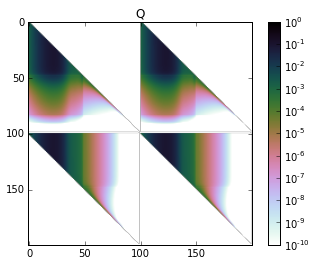

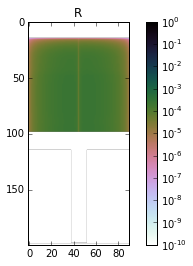

In [48]:
plt.figure()
plt.title("Q")
norm = LogNorm(vmin=1e-10, vmax=1)
plt.imshow(Q, cmap=cm.cubehelix_r, norm=norm)
plt.colorbar();
plt.figure()
plt.title("R")
plt.imshow(R, cmap=cm.cubehelix_r, norm=norm)
plt.colorbar();

<matplotlib.colorbar.Colorbar instance at 0x1085540e0>

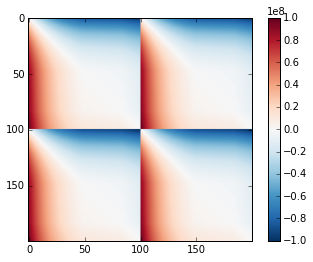

In [49]:
n = np.array( [ s[1] for s in atmosphere.transient ] )
i = np.array( [ s[0] for s in atmosphere.transient ] )
plt.imshow(np.fromiter((z_target - z_source for z_source in atmosphere.z[n]\
 for z_target in atmosphere.z[n]), dtype=np.float ).reshape((len(n),len(n))), cmap=cm.RdBu_r)
plt.colorbar()

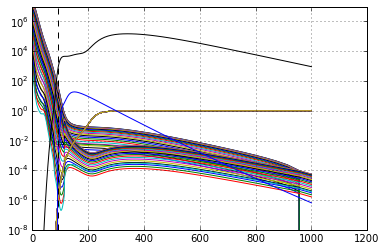

In [50]:
x = atmosphere.z*1e-5
plt.plot( x, atmosphere.tau[0] )
plt.plot( x, atmosphere.dtau[0] )
plt.plot( x, atmosphere.albedo[0] )
plt.plot( x, atmosphere.oplus )
plt.plot( z, S(z*1e5) )
plt.axvline(90, color='k', ls='--')
plt.grid()
plt.ylim(1e-8,1e7)
plt.yscale('log')

In [51]:
# plt.plot(atmosphere.z, msis_n["O"], label="O", ls='--', lw=2)
# plt.plot(atmosphere.z, msis_n["N2"], label="N2", ls='--', lw=2)
# plt.plot(atmosphere.z, msis_n["O2"], label="O2", ls='--', lw=2)
# plt.plot(atmosphere.z, atmosphere.oplus, label="O+", lw=2)
# edp = auric.retrieve("ionos.dat", features=['[e-]'])
# plt.plot(edp["ALT"]*1e5,edp["[e-]"], label="e-", alpha=0.5, lw=2)
# plt.plot()
# plt.legend(); plt.grid(b=True, which='both')
# plt.ylim(1e3,1e6)
# plt.yscale('log')

# Do the viewing angles work?

One way to find out. (The weights are incorrect, so it will probably explode or something.)

In [52]:
X = atmosphere.multiple_scatter_matrix( 2, view_height=600 )
X.shape

(200, 90)

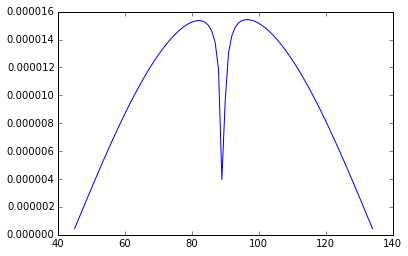

In [53]:
pdf_interp = scipy.interpolate.interp1d( x=z[::-1]*1e5, y=pdf[::-1], bounds_error=False, fill_value=0 )

PI_0 = np.hstack( [pdf_interp(atmosphere.z) / 2]*2 ) 
out = np.dot( PI_0, X )
#plt.plot(PI_0)
viewing_angles = atmosphere.viewing_angles
plt.plot( viewing_angles, out )
#plt.yscale('log')

In [54]:
!say done

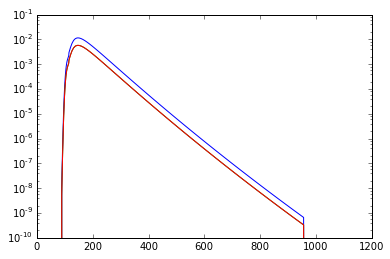

In [55]:
plt.plot(z, pdf)
plt.plot(atmosphere.z*1e-5, PI_0[:atmosphere.N_layers])
plt.plot(atmosphere.z*1e-5, PI_0[atmosphere.N_layers:])
plt.yscale('log')

In [56]:
mu_j = atmosphere.mu[0]
mu_e = -np.cos(viewing_angles[0])
tau = 1.0001
tau_prime = atmosphere.tau[2]
albedo = atmosphere.albedo[2]


# Sanity Check

The sum of each row of Q should be no more than one, since every photon comes from somewhere, but it may be less, because the absorbed photons are not accounted for by any state

(0.0001, 100)

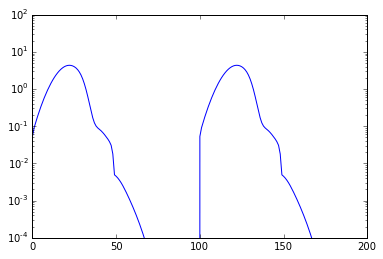

In [57]:
plt.plot(np.sum(Q ,axis=0))#+np.sum(R,axis=1) )
plt.yscale('log')
plt.ylim(1e-4,100)

In [58]:
print np.arange(10).reshape((2,5))
print np.fromiter( (a*b for b in (+1, -1) for a in xrange(5) ), dtype=np.int32).reshape((2,5))

[[0 1 2 3 4]
 [5 6 7 8 9]]
[[ 0  1  2  3  4]
 [ 0 -1 -2 -3 -4]]


In [59]:
kB = 1.3806488e-23 # J / K

# speed of light
c = 2.99792458e8 # m / s

amu = 1.660468E-27 # kg

def sdu( m, T ):
    """Doppler unit for mass `m` and temperature `T`.
    The standard deviation for a doppler-broadened line centered at 'nu' is `sdu( m, T ) * nu` """
    return np.sqrt( kB * T / m / c**2 )


In [60]:
a = np.arange(9).reshape(1,9)


In [61]:
atmosphere.Q((0,5),(0,5),1).shape

()

In [62]:
scipy.special.erf(1e-6)

1.1283791670951364e-06

In [63]:
atmosphere.lineshape[0][5,:]

array([ 0.09851323,  0.09701717,  0.09409289,  0.08987089,  0.08453477,
        0.07830795,  0.07143817,  0.06418137,  0.05678605,  0.04947985,
        0.04245895,  0.03588097,  0.02986161,  0.02447464,  0.01975483,
        0.01570307,  0.01229277,  0.00947696,  0.0071952 ,  0.00537985,
        0.00396143,  0.00287268,  0.00646461])

In [64]:
len(atmosphere.transient), len(atmosphere.ergodic), len(viewing_angles)

(200, 90, 90)

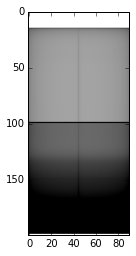

In [65]:
plt.imshow(X, cmap=cm.gray, norm=norm)

In [66]:
R

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -8.85296701e-09,  -2.05975752e-08,  -3.23345489e-08, ...,
         -3.23362834e-08,  -2.05986741e-08,  -8.85343791e-09],
       [ -2.14138303e-08,  -4.98220537e-08,  -7.82118154e-08, ...,
         -7.82159738e-08,  -4.98246883e-08,  -2.14149593e-08],
       ..., 
       [  3.05164569e-90,   5.42197709e-90,   5.23092481e-90, ...,
          1.21407074e-88,   1.23714580e-88,   6.89772599e-89],
       [  1.57294630e-89,   2.79471461e-89,   2.69623824e-89, ...,
          6.25783028e-88,   6.37676882e-88,   3.55537754e-88],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

###TODO
* look at integrals in original
* test `R1` and `T1` to make sure they are reasonable
* test `R` to see if any problems come up in `quad_gen`.
* ...profit? no, probably not

In [67]:
atmosphere.mu_e

array([-0.69441094, -0.693355  , -0.69145661, -0.68871764, -0.68514134,
       -0.68073201, -0.67549495, -0.66943648, -0.66256389, -0.65488546,
       -0.64641045, -0.63714906, -0.62711246, -0.61631274, -0.6047629 ,
       -0.59247688, -0.57946947, -0.56575634, -0.55135403, -0.53627987,
       -0.52055204, -0.50418948, -0.48721192, -0.4696398 , -0.45149431,
       -0.43279729, -0.4135713 , -0.39383948, -0.37362561, -0.35295406,
       -0.33184973, -0.31033804, -0.28844492, -0.26619674, -0.24362032,
       -0.22074286, -0.19759192, -0.17419539, -0.15058148, -0.12677862,
       -0.10281551, -0.07872102, -0.05452417, -0.03025412, -0.00594012,
        0.01838853,  0.04270253,  0.06697258,  0.09116943,  0.11526392,
        0.13922704,  0.16302989,  0.1866438 ,  0.21004033,  0.23319127,
        0.25606873,  0.27864515,  0.30089333,  0.32278645,  0.34429814,
        0.36540247,  0.38607402,  0.40628789,  0.42601971,  0.4452457 ,
        0.46394272,  0.48208821,  0.49966033,  0.51663789,  0.53

In [68]:
x = np.zeros((len(atmosphere.z), len(atmosphere.mu_e)))
for i,b in enumerate(atmosphere.mu_e):
    for a in atmosphere.mu:
        x[0,i] = b
             
print x

[[-0.69441094 -0.693355   -0.69145661 ...,  0.70390502  0.70580341
   0.70685935]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [69]:
atmosphere.mu

array([ 0.57735027, -0.57735027])

In [70]:
np.arccos(atmosphere.mu_e)*180/np.pi

array([ 133.98029521,  133.89627611,  133.74552283,  133.52868448,
        133.2467239 ,  132.90087139,  132.49259792,  132.02358686,
        131.49570381,  130.91096546,  130.27150843,  129.57955904,
        128.83740476,  128.04736801,  127.21178257,  126.33297293,
        125.41323666,  124.4548297 ,  123.45995449,  122.43075071,
        121.3692884 ,  120.27756315,  119.15749314,  118.01091777,
        116.8395975 ,  115.64521489,  114.4293764 ,  113.19361492,
        111.93939284,  110.66810547,  109.38108479,  108.07960335,
        106.76487831,  105.43807553,  104.10031369,  102.75266837,
        101.39617611,  100.03183839,   98.66062557,   97.28348072,
         95.90132343,   94.51505351,   93.12555465,   91.73369805,
         90.34034597,   88.94635525,   87.5525809 ,   86.15987956,
         84.76911307,   83.38115203,   81.99687941,   80.6171942 ,
         79.24301512,   77.87528443,   76.51497178,   75.16307821,
         73.82064017,   72.4887337 ,   71.16847859,   69.86104

In [71]:
from mcrt.los import integrate_line_of_sight_plane_parallel, line_of_sight_depth, r_of_t, viewing_row
ver = SF
absorb_coeff = atmosphere.extinction 
tau = atmosphere.tau[2]
z = atmosphere.z
height = 600e5
theta = 95*np.pi/180
los = integrate_line_of_sight_plane_parallel(theta, height, ver, absorb_coeff, tau, z)
los

ValueError: operands could not be broadcast together with shapes (100,) (100,23) 

In [ ]:
atmosphere